In [1]:
import re
import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from keras.models import Model
from keras.models import load_model
from keras.layers import Input, Dense, GRU, concatenate
from keras import metrics
from keras import backend as K
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# Custom library for the project
import sys
sys.path.insert(0, '../../src')
import harmoutil

%matplotlib inline

/home/maxime/.local/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# # Remove when done with kernel
import importlib
importlib.reload(harmoutil)

<module 'harmoutil' from '../../src/harmoutil.py'>

In [3]:
# Load data
raw_data = harmoutil.load_pickled_data("../../data/refined_data.pkl") # lists of (chord label, melody seqs) by sections
augmented_data = harmoutil.transpose_and_augment_data(raw_data)
data = [harmoutil.to_sevenths(section) for section in augmented_data]
data = [harmoutil.melody_to_octave_range(section) for section in data]

In [4]:
# Isolate relevant data
def get_notes_by_chord(beats):
    return [note for beat in beats for note in beat]

def get_chords_by_section(section):
    return [chord_info[0] for chord_info in section]

# def check_if_augmented_major(section):
#     section_chords = get_chords_by_section(section)
#     for ch in section_chords:
#         if "+j7" in ch:
#             return True
#     return False


# Remove sections that involve augmented major chords (since not enough data to even allow StratifiedShuffleSplit)
# data = [section for section in data if not check_if_augmented_major(section)]
# print("---Remove sections with augmented major chord---")
# print("Number of sections: {}\n".format(len(data)))

chords_by_sections_bf_augmaj7 = [get_chords_by_section(section) for section in data]
chords = [chord_info[0] for section in data for chord_info in section]
unique_chords = sorted(list(set(chords)))

notes_by_chords_bf_augmaj7 = [get_notes_by_chord(chord_info[1]) for section in data for chord_info in section]
notes = [note for chord_notes in notes_by_chords_bf_augmaj7 for note in chord_notes]
unique_notes = sorted(list(set(notes)))

# print(sum([len(section) for section in chords_by_sections]))
# print("Number of sections: {} | Sample section chords: {}".format(len(chords_by_sections), chords_by_sections[0]))
print("Number of chords: {} | Sample chord: {}".format(len(chords), chords[0]))
# print("Number of melodies {} | Sample melody: {}".format(len(notes_by_chords), notes_by_chords[0]))
print("Number of melody notes in the data: {} | Sample melody note: {}".format(len(notes), notes[0]))
print("Unique notes: {}".format(unique_notes))
print("Unique notes: {}".format(unique_chords))

Number of chords: 334344 | Sample chord: E6
Number of melody notes in the data: 2209944 | Sample melody note: 4
Unique notes: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Unique notes: ['A', 'A+', 'A+7', 'A+j7', 'A-', 'A-6', 'A-7', 'A-j7', 'A6', 'A7', 'Ab', 'Ab+', 'Ab+7', 'Ab+j7', 'Ab-', 'Ab-6', 'Ab-7', 'Ab-j7', 'Ab6', 'Ab7', 'Abj7', 'Abm7b5', 'Abo', 'Abo7', 'Absus', 'Absus7', 'Aj7', 'Am7b5', 'Ao', 'Ao7', 'Asus', 'Asus7', 'B', 'B+', 'B+7', 'B+j7', 'B-', 'B-6', 'B-7', 'B-j7', 'B6', 'B7', 'Bb', 'Bb+', 'Bb+7', 'Bb+j7', 'Bb-', 'Bb-6', 'Bb-7', 'Bb-j7', 'Bb6', 'Bb7', 'Bbj7', 'Bbm7b5', 'Bbo', 'Bbo7', 'Bbsus', 'Bbsus7', 'Bj7', 'Bm7b5', 'Bo', 'Bo7', 'Bsus', 'Bsus7', 'C', 'C+', 'C+7', 'C+j7', 'C-', 'C-6', 'C-7', 'C-j7', 'C6', 'C7', 'Cj7', 'Cm7b5', 'Co', 'Co7', 'Csus', 'Csus7', 'D', 'D+', 'D+7', 'D+j7', 'D-', 'D-6', 'D-7', 'D-j7', 'D6', 'D7', 'Db', 'Db+', 'Db+7', 'Db+j7', 'Db-', 'Db-6', 'Db-7', 'Db-j7', 'Db6', 'Db7', 'Dbj7', 'Dbm7b5', 'Dbo', 'Dbo7', 'Dbsus', 'Dbsus7', 'Dj7', 'Dm7b5', 'Do', 'Do7', '

In [5]:
# Create categorical data mappings
note_to_int = dict([(c, i) for i, c in enumerate(unique_notes[1:])])
note_to_int[-1] = len(note_to_int)
note_to_int['<pad>'] = len(note_to_int)

int_to_note = dict([(k, v) for v, k in note_to_int.items()])

chord_to_int = dict([(c, i) for i, c in enumerate(unique_chords)])
chord_to_int['<bos>'] = len(chord_to_int)
chord_to_int['<eos>'] = len(chord_to_int)

int_to_chord = dict([(k, v) for v, k in chord_to_int.items()])

print("Melody note to integer mapping:\n {}\n".format(note_to_int))
print("Integer to melody note mapping:\n {}\n".format(int_to_note))
print("Chord label to integer mapping:\n {}\n".format(chord_to_int))
print("Integer to chord label mapping:\n {}\n".format(int_to_chord))

Melody note to integer mapping:
 {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, '<pad>': 13, -1: 12}

Integer to melody note mapping:
 {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: -1, 13: '<pad>'}

Chord label to integer mapping:
 {'Csus7': 79, 'Cj7': 74, 'Bb': 42, 'Gbo': 182, 'Dm7b5': 107, '<bos>': 193, 'Eo7': 141, 'Abo7': 23, 'A6': 8, 'B-6': 37, 'Am7b5': 27, 'G': 160, 'C6': 72, 'D': 80, 'Bsus': 62, 'Dsus7': 111, 'Eb+j7': 125, 'Gbj7': 180, 'Db+7': 92, 'C-j7': 71, 'F-7': 150, 'Ab': 10, 'Csus': 78, 'Fsus7': 159, 'Go7': 189, 'Gb': 170, 'Dbsus7': 105, 'E-6': 117, 'E7': 121, 'Gb-6': 175, 'Bb+7': 44, 'Co7': 77, 'Asus': 30, 'F+j7': 147, 'Ab+j7': 13, 'E-': 116, 'Eb+': 123, 'Bbsus7': 57, 'Eb-7': 128, 'Ab-': 14, 'B-j7': 39, 'D-7': 86, 'Gsus': 190, 'Absus': 24, 'Ab-7': 16, 'Dsus': 110, 'Bbo': 54, 'Gb+7': 172, 'Ebo': 134, 'Eb-': 126, 'Bb-j7': 49, 'Ebsus': 136, 'Gj7': 186, 'NC': 192, 'F6': 152, 'E6': 120, 'C-': 68, 'A-7': 6, 'Gb6': 

In [6]:
# Define numerical variables

n_samples = len(chords)
n_chords = len(chord_to_int)
n_notes = len(note_to_int)
max_mel_len = max([len(mel) for mel in notes_by_chords_bf_augmaj7])
chord_context_len = 7

# print("Total number of samples: {}".format(n_samples))
print("Total number of samples: {}".format(n_samples))
print("Number of distinct melody notes: {}".format(n_notes))
print("Number of distinct chord labels: {}".format(n_chords))
print("Maximum length of melody sequences for one chord: {}".format(max_mel_len))
print("Number of past chords given as input: {}".format(chord_context_len))

Total number of samples: 334344
Number of distinct melody notes: 14
Number of distinct chord labels: 195
Maximum length of melody sequences for one chord: 135
Number of past chords given as input: 7


In [7]:
mel_by_sections = [mel for section in data for ch, mel in section]
print(mel_by_sections[0])

[[4], [4]]


In [8]:
# Prepare tensor data


def check_if_augmented_major(section):
    section_chords = get_chords_by_section(section)
    for ch in section_chords:
        if "+j7" in ch:
            return True
    return False


# Remove sections that involve augmented major chords (since not enough data to even allow StratifiedShuffleSplit)
data = [section for section in data if not check_if_augmented_major(section)]
print("---Remove sections with augmented major chord---")
print("Number of sections: {}\n".format(len(data)))

chords_by_sections = [get_chords_by_section(section) for section in data]
# chords = [chord_info[0] for section in data for chord_info in section]
# unique_chords = sorted(list(set(chords)))

notes_by_chords = [get_notes_by_chord(chord_info[1]) for section in data for chord_info in section]
# notes = [note for chord_notes in notes_by_chords for note in chord_notes]
# unique_notes = sorted(list(set(notes)))



def pad_melody(melody, max_len):
    return melody + (max_len-len(melody))*['<pad>']

def build_input_chord_sequences(chord_seq, context_len):
    padded_sequence = context_len*['<bos>'] + chord_seq
    formatted_sequences = [padded_sequence[i:i+context_len+1] for i in range(len(chord_seq))]
    return formatted_sequences

# Melody
input_melody_data = [pad_melody(melody, max_mel_len) for melody in notes_by_chords]
print("Sample input melody sequence: {}\n".format(input_melody_data[5]))

# Chords
formatted_chords_data = []
for section_chords in chords_by_sections:
    formatted_chords_data += build_input_chord_sequences(section_chords, chord_context_len)
    
input_chords_data = [ch[:-1] for ch in formatted_chords_data]
target_chords_data = [ch[-1] for ch in formatted_chords_data]
print("Sample input chord sequence: {}\n".format(input_chords_data[5]))
print("Sample target chord: {}\n".format(target_chords_data[5]))

print("Input melody: {}, Input chords: {}, Target chords: {}".format(len(input_melody_data), len(input_chords_data), len(target_chords_data)))

---Remove sections with augmented major chord---
Number of sections: 28836

Sample input melody sequence: [8, 3, 6, '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<

In [10]:
# Load embedding vectors

num_dim = 32
num_ch = 192
num_notes = 12

# Define embedding training model and load weights
input_layer = Input(shape=(num_ch,)) 
embeddings_layer = Dense(num_dim, activation='linear', name="embeddings")(input_layer)
root_output_layer = Dense(num_notes, activation='softmax')(embeddings_layer)
interval_output_layer = Dense(num_notes, activation='sigmoid')(embeddings_layer)
pitch_output_layer = Dense(num_notes, activation='sigmoid')(embeddings_layer)
melody_output_layer = Dense(num_notes, activation='relu')(embeddings_layer)
embeddings_model = Model(input_layer, [root_output_layer, interval_output_layer, pitch_output_layer, melody_output_layer])

embeddings_model.load_weights("../Skipgram & WJD/weights/combined_weights_dim32.h5")

X_chords_embeddings = embeddings_model.layers[1].get_weights()[0]
print(X_chords_embeddings.shape)


(192, 32)


In [11]:
# Build tensors

n_dimensions = X_chords_embeddings.shape[1]
print("Size of embedding vector for each chord: {}".format(n_dimensions))

X_melody = np.zeros((n_samples, max_mel_len, n_notes), dtype='float32')
X_chords = np.zeros((n_samples, chord_context_len, n_dimensions), dtype='float32')
Y_chord = np.zeros((n_samples, n_chords), dtype='float32')

for i, (input_mel, input_ch, target_ch) in enumerate(zip(input_melody_data, input_chords_data, target_chords_data)):
    Y_chord[i, chord_to_int[target_ch]] = 1
    for j, chord in enumerate(input_ch):
#         X_chords[i, j, chord_to_int[chord]] = 1
        chord_index = chord_to_int[chord]
        if (chord_index < num_ch):
            X_chords[i, j, :] = X_chords_embeddings[chord_index, :]
    
    for j, note in enumerate(input_mel):
        X_melody[i, j, note_to_int[note]] = 1

Size of embedding vector for each chord: 32


In [12]:
print(X_melody.shape)
print(X_chords.shape)
print(Y_chord.shape)

(334344, 135, 14)
(334344, 7, 32)
(334344, 195)


In [13]:
# Split dataset into 80%-10%-10% train-valid-test sets
seed = 0

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)

for train_index, aux_index in sss.split(X_chords, Y_chord):
    X_melody_train, X_melody_aux = X_melody[train_index], X_melody[aux_index]
    X_chords_train, X_chords_aux = X_chords[train_index], X_chords[aux_index]
    Y_chord_train, Y_chord_aux = Y_chord[train_index], Y_chord[aux_index]
    
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=seed)

for valid_index, test_index in sss.split(X_chords_aux, Y_chord_aux):
    X_melody_valid, X_melody_test = X_melody[valid_index], X_melody[test_index]
    X_chords_valid, X_chords_test = X_chords[valid_index], X_chords[test_index]
    Y_chord_valid, Y_chord_test = Y_chord[valid_index], Y_chord[test_index]

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 135, 14)       0                                            
____________________________________________________________________________________________________
input_4 (InputLayer)             (None, 7, 32)         0                                            
____________________________________________________________________________________________________
gru_1 (GRU)                      (None, 128)           54912       input_3[0][0]                    
____________________________________________________________________________________________________
gru_2 (GRU)                      (None, 128)  

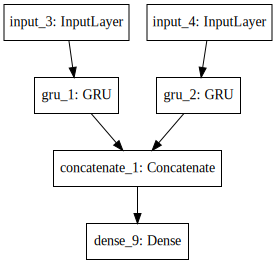

In [14]:
# Define neual net architecture

latent_dim = 128

melody_input = Input(shape=(max_mel_len, n_notes))
melody_gru = GRU(latent_dim)(melody_input)

chords_input = Input(shape=(chord_context_len, n_dimensions))
chords_gru = GRU(latent_dim)(chords_input)

concat = concatenate([melody_gru, chords_gru])

chord_dense = Dense(n_chords, activation='softmax')(concat)

model = Model([melody_input, chords_input], chord_dense)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [15]:
# Introduce Best-Performance callbacks
# es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')
filepath = "models/embeddings32-Mel1-Cho1-FC1_150ep.h5"
bp = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [16]:
# Train model
batch_size = 256
epochs = 150

history = model.fit([X_melody_train, X_chords_train], Y_chord_train, epochs=epochs, validation_data=([X_melody_valid, X_chords_valid], Y_chord_valid), batch_size=batch_size, callbacks=[bp])

Train on 267475 samples, validate on 33434 samples
Epoch 1/150
267475/267475 [==============================] - 430s - loss: 2.8940 - acc: 0.3496 - val_loss: 2.5612 - val_acc: 0.4163
Epoch 2/150
267475/267475 [==============================] - 433s - loss: 2.3802 - acc: 0.4445 - val_loss: 2.3411 - val_acc: 0.4567
Epoch 3/150
267475/267475 [==============================] - 434s - loss: 2.1789 - acc: 0.4831 - val_loss: 2.2037 - val_acc: 0.4900
Epoch 4/150
267475/267475 [==============================] - 435s - loss: 2.0367 - acc: 0.5147 - val_loss: 2.1163 - val_acc: 0.5196
Epoch 5/150
267475/267475 [==============================] - 434s - loss: 1.9260 - acc: 0.5409 - val_loss: 2.0547 - val_acc: 0.5311
Epoch 6/150
267475/267475 [==============================] - 434s - loss: 1.8360 - acc: 0.5622 - val_loss: 1.9890 - val_acc: 0.5498
Epoch 7/150
267475/267475 [==============================] - 433s - loss: 1.7637 - acc: 0.5803 - val_loss: 1.9540 - val_acc: 0.5621
Epoch 8/150
267475/267475

267475/267475 [==============================] - 436s - loss: 1.2920 - acc: 0.6859 - val_loss: 1.7038 - val_acc: 0.6272
Epoch 27/150
267475/267475 [==============================] - 436s - loss: 1.2831 - acc: 0.6876 - val_loss: 1.6989 - val_acc: 0.6262
Epoch 28/150
267475/267475 [==============================] - 436s - loss: 1.2759 - acc: 0.6887 - val_loss: 1.6959 - val_acc: 0.6280
Epoch 29/150
267475/267475 [==============================] - 436s - loss: 1.2680 - acc: 0.6904 - val_loss: 1.6869 - val_acc: 0.6274
Epoch 30/150
267475/267475 [==============================] - 435s - loss: 1.2611 - acc: 0.6920 - val_loss: 1.6884 - val_acc: 0.6314
Epoch 31/150
267475/267475 [==============================] - 435s - loss: 1.2539 - acc: 0.6931 - val_loss: 1.6881 - val_acc: 0.6293
Epoch 32/150
267475/267475 [==============================] - 435s - loss: 1.2479 - acc: 0.6940 - val_loss: 1.6847 - val_acc: 0.6331
Epoch 33/150
267475/267475 [==============================] - 435s - loss: 1.2418 

267475/267475 [==============================] - 433s - loss: 1.1308 - acc: 0.7152 - val_loss: 1.6235 - val_acc: 0.6500
Epoch 54/150
267475/267475 [==============================] - 433s - loss: 1.1219 - acc: 0.7163 - val_loss: 1.6421 - val_acc: 0.6467
Epoch 55/150
267475/267475 [==============================] - 434s - loss: 1.1344 - acc: 0.7137 - val_loss: 1.6210 - val_acc: 0.6522
Epoch 56/150
267475/267475 [==============================] - 434s - loss: 1.1226 - acc: 0.7161 - val_loss: 1.6075 - val_acc: 0.6525
Epoch 57/150
267475/267475 [==============================] - 434s - loss: 1.1163 - acc: 0.7166 - val_loss: 1.6121 - val_acc: 0.6507
Epoch 58/150
267475/267475 [==============================] - 435s - loss: 1.1116 - acc: 0.7175 - val_loss: 1.6067 - val_acc: 0.6519
Epoch 59/150
267475/267475 [==============================] - 435s - loss: 1.1075 - acc: 0.7186 - val_loss: 1.6026 - val_acc: 0.6556
Epoch 60/150
267475/267475 [==============================] - 435s - loss: 1.1044 

267475/267475 [==============================] - 432s - loss: 1.0118 - acc: 0.7353 - val_loss: 1.5248 - val_acc: 0.6722
Epoch 82/150
267475/267475 [==============================] - 433s - loss: 1.0029 - acc: 0.7374 - val_loss: 1.5205 - val_acc: 0.6670
Epoch 83/150
267475/267475 [==============================] - 433s - loss: 0.9931 - acc: 0.7386 - val_loss: 1.4929 - val_acc: 0.6747
Epoch 84/150
267475/267475 [==============================] - 433s - loss: 0.9846 - acc: 0.7406 - val_loss: 1.4948 - val_acc: 0.6742
Epoch 85/150
267475/267475 [==============================] - 433s - loss: 0.9778 - acc: 0.7413 - val_loss: 1.5159 - val_acc: 0.6705
Epoch 86/150
267475/267475 [==============================] - 434s - loss: 0.9869 - acc: 0.7394 - val_loss: 1.4746 - val_acc: 0.6796
Epoch 87/150
267475/267475 [==============================] - 436s - loss: 0.9692 - acc: 0.7432 - val_loss: 1.4796 - val_acc: 0.6801
Epoch 88/150
267475/267475 [==============================] - 435s - loss: 0.9605 

267475/267475 [==============================] - 429s - loss: 0.8783 - acc: 0.7635 - val_loss: 1.4432 - val_acc: 0.6877
Epoch 112/150
267475/267475 [==============================] - 429s - loss: 0.8884 - acc: 0.7604 - val_loss: 1.4465 - val_acc: 0.6876
Epoch 113/150
267475/267475 [==============================] - 429s - loss: 0.8750 - acc: 0.7635 - val_loss: 1.4423 - val_acc: 0.6885
Epoch 114/150
267475/267475 [==============================] - 434s - loss: 0.8614 - acc: 0.7671 - val_loss: 1.4484 - val_acc: 0.6906
Epoch 115/150
267475/267475 [==============================] - 435s - loss: 0.8661 - acc: 0.7659 - val_loss: 1.4434 - val_acc: 0.6901
Epoch 116/150
267475/267475 [==============================] - 436s - loss: 0.8595 - acc: 0.7675 - val_loss: 1.4456 - val_acc: 0.6828
Epoch 117/150
267475/267475 [==============================] - 435s - loss: 0.8572 - acc: 0.7678 - val_loss: 1.5106 - val_acc: 0.6742
Epoch 118/150
267475/267475 [==============================] - 435s - loss: 

267475/267475 [==============================] - 430s - loss: 0.8654 - acc: 0.7641 - val_loss: 1.4653 - val_acc: 0.6900
Epoch 142/150
267475/267475 [==============================] - 430s - loss: 0.8639 - acc: 0.7649 - val_loss: 1.4718 - val_acc: 0.6860
Epoch 143/150
267475/267475 [==============================] - 430s - loss: 0.8615 - acc: 0.7660 - val_loss: 1.4768 - val_acc: 0.6862
Epoch 144/150
267475/267475 [==============================] - 430s - loss: 0.8596 - acc: 0.7660 - val_loss: 1.4759 - val_acc: 0.6855
Epoch 145/150
267475/267475 [==============================] - 430s - loss: 0.8581 - acc: 0.7671 - val_loss: 1.4675 - val_acc: 0.6883
Epoch 146/150
267475/267475 [==============================] - 429s - loss: 0.8570 - acc: 0.7671 - val_loss: 1.4588 - val_acc: 0.6906
Epoch 147/150
267475/267475 [==============================] - 429s - loss: 0.8545 - acc: 0.7672 - val_loss: 1.4675 - val_acc: 0.6869
Epoch 148/150
267475/267475 [==============================] - 430s - loss: 

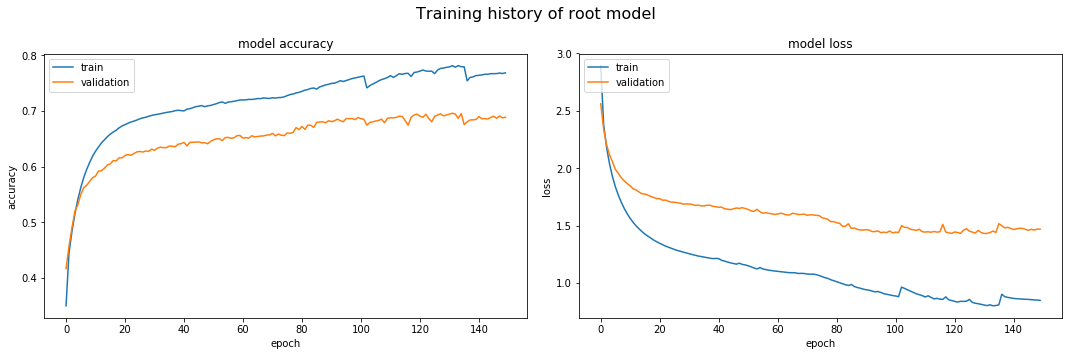

In [17]:
# Visualize model learning
plt.clf()

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# plt.show()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.tight_layout()
plt.suptitle("Training history of root model", fontsize=16)
plt.subplots_adjust(top=0.85)
plt.show()

In [18]:
# Load best performance model
best_model = load_model("models/embeddings32-Mel1-Cho1-FC1_150ep.h5")

In [19]:
print(X_melody_test.shape)
print(X_chords_test.shape)

(33435, 135, 14)
(33435, 7, 32)


In [20]:
# Evaluate predictions in terms of labels

# Predict chords from each test sample melody
Y_chord_pred = model.predict([X_melody_test, X_chords_test])

# Compute accuracy and kappa score 
print("Categorical accuracy of combined chord prediction: {0:.4f}".format(harmoutil.compute_accuracy_score(Y_chord_test, Y_chord_pred)))
print("Kappa score of combined chord prediction: {0:.4f}".format(harmoutil.compute_kappa_score(Y_chord_test, Y_chord_pred)))

Categorical accuracy of combined chord prediction: 0.6886
Kappa score of combined chord prediction: 0.6809


In [21]:
# Evaluate predictions in terms of pitches

def label_to_pitch_tensors(predictions):
    predicted_chords = [int_to_chord[np.argmax(ch)] for ch in predictions]
    pitch_chords = [harmoutil.chord_to_notes(label) for label in predicted_chords]
    
    Y_pitches = np.zeros((predictions.shape[0], 12), dtype='float32')
    for i, chord_pitches in enumerate(pitch_chords):
        for j, pitch_presence in enumerate(chord_pitches):
            Y_pitches[i, j] = pitch_presence

    return Y_pitches

Y_pitch_pred = label_to_pitch_tensors(Y_chord_pred)
Y_pitch_test = label_to_pitch_tensors(Y_chord_test)

print("Categorical accuracy of combined chord pitch prediction: {0:.4f}".format(harmoutil.compute_multiclass_binary_accuracy_score(Y_pitch_test, Y_pitch_pred)))
print("Kappa score of combined chord pitch prediction: {0:.4f}".format(harmoutil.compute_multiclass_binary_kappa_score(Y_pitch_test, Y_pitch_pred)))


Categorical accuracy of combined chord pitch prediction: 0.8890
TP: 108343 TN: 248358 FP: 22409 FN: 22110
Kappa score of combined chord pitch prediction: 0.7473
